In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar


In [2]:
tckrs = ["ADBE", "AMAT", "AMZN", "BRK-B", "DAL", "GOOG", "MCD"]

In [58]:
start = "2020-03-18"
end = "2021-11-01"

In [59]:
dates = pd.date_range(start, end)

In [60]:
base = "/home/greg_b/voltron/experiments/trading/saved-outputs/"

In [61]:
full_predictions = []
has_dates = []
keep_dates = []
for date in dates:
    cap = str(date)[:10]
    try:
        predictions = torch.stack([torch.load(base + tckr + "/volt_ewma400_"+cap+".pt") for tckr in tckrs])
        full_predictions.append(predictions)
        has_dates.append(cap)
        keep_dates.append(cap)
    except:
        pass
        # print(cap)

In [62]:
daily_predictions = torch.stack(full_predictions)
num_obs = daily_predictions.shape[0]

In [63]:
daily_predictions.shape

torch.Size([411, 7, 1000, 20])

In [64]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
end_plus_20 = str(pd.date_range(start=end, periods=21, freq=bday_us)[-1])[:10]
observations = torch.tensor(
    [yf.download(tckr, start=start, end=end_plus_20).Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [78]:
lookahead = 19
idcs = torch.arange(0, daily_predictions.shape[0] - lookahead, lookahead)

In [79]:
returns = (observations[..., idcs+lookahead] / observations[..., idcs]) - 1.

In [80]:
lookahead_preds = daily_predictions[..., lookahead].permute(1, 2, 0)
exp_means = lookahead_preds.exp().mean(1)
exp_stds = lookahead_preds.exp().std(1)

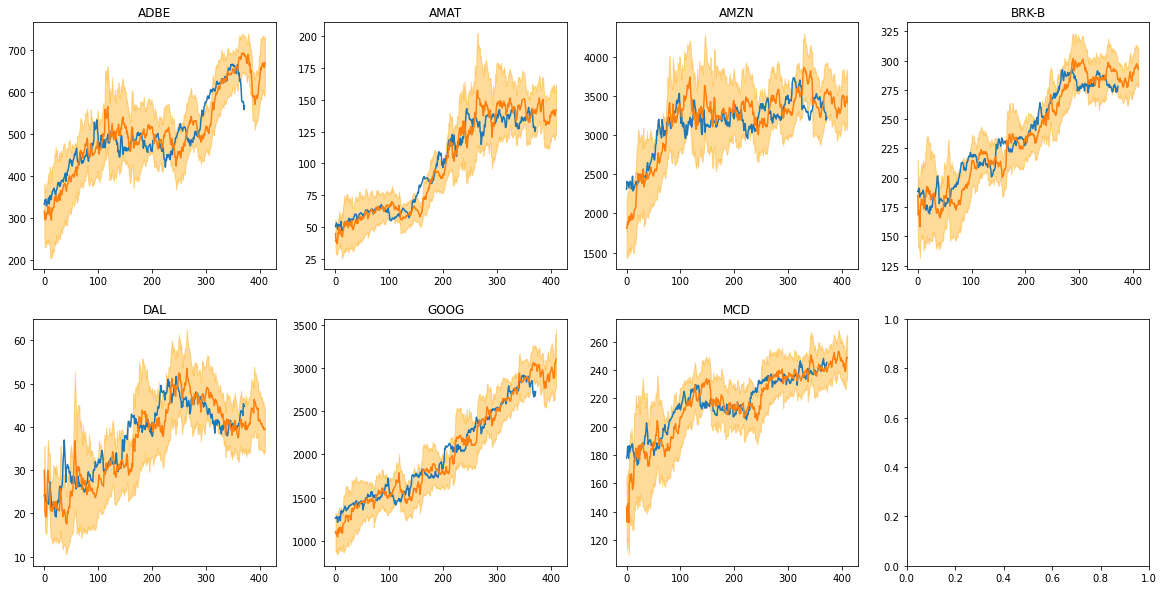

In [81]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].plot(observations[i, lookahead:-(20+lookahead)])
    ax[i].plot(exp_means[i])
    ax[i].fill_between(
        torch.arange(num_obs), 
        (exp_means - 2 * exp_stds)[i],
        (exp_means + 2 * exp_stds)[i],
        alpha = 0.4, 
        color = "orange"
    )
    ax[i].set_title(tckrs[i])

## Setup Cov and Obs

In [82]:
returns = (observations[:, 1:] - observations[:, :-1])/(observations[:, :-1])
cov_est = returns.cov()

In [83]:
def compute_strategy(preds, pxs, cov_est=None, normalize = True, interest_rate=0.03):
    excess_returns = (preds.exp().mean(-1) - pxs)/pxs - interest_rate * lookahead/252.
    if cov_est is None:
        batched_covs = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])
    else:
        batched_covs = cov_est
    
    weights = torch.solve(excess_returns.t().unsqueeze(-1), batched_covs)[0]
    
    # weights = weights.clamp(min=0.)
    
    norm_constant = excess_returns.t().unsqueeze(-2).matmul(weights).sum(-1)
    
    res = weights.squeeze(-1) / norm_constant
    if normalize:
        res = res / res.abs().sum()
        
    return res
    

## Loop and Run Through Strat

In [84]:
lookahead = 5
num_trading_days = daily_predictions.shape[0]
nstock = daily_predictions.shape[1]
volt_portfolio_value = 10000.
hold_portfolio_value = 10000.
start_date = pd.to_datetime(keep_dates[0]).date() - pd.to_timedelta("1 day")
logger = [[keep_dates[0], hold_portfolio_value] + [0. for _ in range(nstock)] +  ["Hold"]]
logger = [[keep_dates[0], volt_portfolio_value] + [0. for _ in range(nstock)] +  ["Volt"]]
hold_wghts = 1./nstock * torch.ones(nstock)
for idx in range(num_trading_days):
    if idx > 0: 
        ## update portfolio value
        new_px = observations[:, idx]
        holdings = volt_portfolio_value * wghts
        updates = holdings * (new_px - curr_px)/new_px
        volt_portfolio_value = volt_portfolio_value + updates.sum()
        logger.append([keep_dates[idx], volt_portfolio_value.item()] + list(updates.numpy()) + ["Volt"])
        old_px = curr_px
        
        holdings = hold_portfolio_value * hold_wghts
        updates = holdings * (new_px - curr_px)/new_px
        hold_portfolio_value = hold_portfolio_value + updates.sum()
        logger.append([keep_dates[idx], hold_portfolio_value.item()] + list(updates.numpy()) + ["Hold"])

        
    
    curr_px = observations[:, idx]
    pred_std = daily_predictions[idx, :, :, lookahead-1].std(-1)
    cov_est.diagonal().copy_(pred_std);
    wghts = compute_strategy(daily_predictions[idx, :, :, lookahead-1],
                             curr_px,
                             cov_est)
    
    
    

In [85]:
df = pd.DataFrame(logger)
df.columns = ['Date', 'Portfolio'] + ["earnings" + str(i) for i in range(daily_predictions.shape[1])] + ["Type"]

Text(0.5, 1.0, 'Start Date = 2020-03-18')

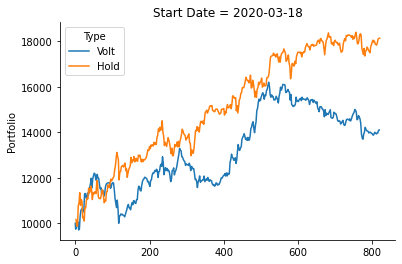

In [86]:
sns.lineplot(x=df.index,  y='Portfolio', hue='Type', data=df)
sns.despine()
plt.title("Start Date = " + keep_dates[0])